In [26]:
import numpy as np
import matplotlib.pyplot as plt 
import string
#%matplotlib.pyplot.inline

# Final Project Notebook
For general notes, practice code to be copy-pasted into actual module, etc

Goal: generate rocket-simulating module with ability to process motor curves, assess Cd's, and produce usable result of graphs (altitude, velocity, acceleration) and output (apogee, max speed/acceleration) based on a variety of user input. Allow userse to change parameters such that assumptions can be modified (basically, if someone wants to model a rocket on mars, they should have the ability to do so). Bonus: estimate potential error in the estimate, with some error bars provided on the graphs, uncertainties given on apogee/maximums.

References:
- http://openrocket.sourceforge.net/techdoc.pdf
- http://www.thrustcurve.org/simfilesearch.jsp?id=485
- https://www.grc.nasa.gov/www/k-12/airplane/atmosmet.html
- http://www-mdp.eng.cam.ac.uk/web/library/enginfo/aerothermal_dvd_only/aero/fprops/propsoffluids/node5.html

#### Motor Curves
Collect txt files for motor curves from: http://www.thrustcurve.org/simfilesearch.jsp?id=485, which has a bunch that can be thrown in with this folder such that they can be accessed/integrated/etc<br>
They are in the format (this stolen from H210Aerotech)<br>
THRUST<br>
; AeroTech H210R<br>
; provided by ThrustCurve.org (www.thrustcurve.org)<br>
; total weight: 246g, propellant weight: 121g<br>
0.00	0.00<br>
0.02	121.16<br>
0.07	214.10<br>
0.12	225.03<br>
0.17	233.41<br>
0.21	240.67<br>
0.26	242.94<br>
0.31	245.71<br>
0.36	251.84<br>
0.41	256.59<br>
0.45	259.87<br>
0.50	258.11<br>
0.55	258.82<br>
0.60	255.30<br>
0.65	250.47<br>
0.69	225.34<br>
0.74	209.64<br>
0.79	199.35<br>
0.84	191.39<br>
0.89	175.31<br>
0.93	84.52<br>
0.98	15.97<br>
-1.00<br>

Let's see if we can import this easily:

In [44]:
motors={}
motorfiles = ['H210R']
for filename in motorfiles:
    z = open('motor_curves/'+filename+'.txt')
    time_force=[]
    for line in z:
        try:
            float(line[0])
            time_force.append(line.split())
        except ValueError:
            continue
    motors[filename]=time_force
    z.close()

print motors
#kind of gross, but effective; can be looped for list of all motors curves that are saved, just need a list of file names
#users could very very easily add their own motor curves to the motor_curves folder, could be provided as a zip or something
#maybe only load motor if requested... if so, need a try/catch for case where motor file isnt found, would save processing time if there are tons of motor curves in the file

{'H210R': [['0.00', '0.00'], ['0.02', '121.16'], ['0.07', '214.10'], ['0.12', '225.03'], ['0.17', '233.41'], ['0.21', '240.67'], ['0.26', '242.94'], ['0.31', '245.71'], ['0.36', '251.84'], ['0.41', '256.59'], ['0.45', '259.87'], ['0.50', '258.11'], ['0.55', '258.82'], ['0.60', '255.30'], ['0.65', '250.47'], ['0.69', '225.34'], ['0.74', '209.64'], ['0.79', '199.35'], ['0.84', '191.39'], ['0.89', '175.31'], ['0.93', '84.52'], ['0.98', '15.97']]}


#### Drag: Atmospheric Modeling

from https://www.spaceacademy.net.au/watch/debris/atmosmod.htm, we have that density can be measured by $\rho=\rho_{0}e^{\frac{h}{H}}$, where h is the height above the surface, and H is the scale height with the equation: $H=\frac{k_BT}{mg}$ where m is the average molecular mass of the atmosphere (which is pretty consistent below 100km). <br>
$k_B= 1.38064852*10^{-23} \frac{m^2kg}{s^2K}$ <br>
$m = .7809*massN + .2095*massO + 0.0093*massAr + 0.0004*massCO2$, where massN=2.3258671e-26, massO=2.6566962e-26, massAr=6.6335209e-26, massCO2=7.3065426768515e-26 all in kg, so:

In [2]:
massN=2.3258671e-26
massO=2.6566962e-26
massAr=6.6335209e-26
massCO2=7.3065427e-26
m= .7809*massN + .2095*massO + 0.0093*massAr + 0.0004*massCO2
print(m)

2.43746183374e-26


$m=2.43746183374*10^{-26} kg$

But, fuck, that's only for isothermic, which is a bad model. Instead, let's use https://www.grc.nasa.gov/www/k-12/airplane/atmosmet.html, which has more clear and pre-derived equations on density and temperature. This model is valid in a justifiable approximation up to 11000m, or 36000ft. <br>
$p=101.29 * [\frac{(T + 273.1)}{288.08}]^{5.256}$ where $p$ is the pressure in kPascals, and T is the temp in degC <br>
$T = 15.04 - .00649 * h $ for an altitude h in meters<br>
$\rho = \frac{p}{[.2869 * (T + 273.1)]}$ for a density in kg/m^3
Using this, we get the following curves for temp and density as a function of height:

Text(0,0.5,u'Pressure(kPa), Temp(C), Density (normed)')

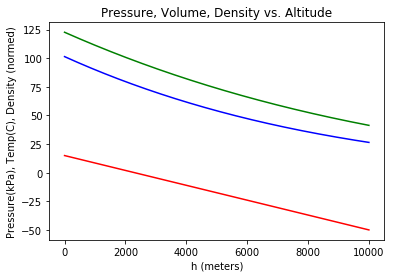

In [23]:
h=np.linspace(0,10000,1000)
def pressure(T):
    return 101.29 * np.power([(T+273.1)/288.08],5.256)
def temp(h):
    return 15.04 - 0.00649*h
def density(T,p):
    return p/(.2869*(T+273.1))
Temp = temp(h)
Press=pressure(Temp)
dens = density(Temp,Press[0]) *100

plt.plot(h,Temp,'-',c='red',label='Temp')
plt.plot(h,Press[0],'-',c='blue',label = 'Pressure')
plt.plot(h,dens,'-',c='green',label = 'Density')
plt.title('Pressure, Volume, Density vs. Altitude')
plt.xlabel('h (meters)')
plt.ylabel('Pressure(kPa), Temp(C), Density (normed)')

Which is both pretty and seems like a valid model, within a decent approx

#### Now, for some Drag
drag force is $D=.5*C_d*\rho*A_{ref}*v^2$, where $C_d$ is calculated using experimental methods, and depends on which surface area is taken. I'll be using the drag calcs from the OpenRocket documentation, which indicate that
$C_{d,friction}=C_{f_c}\frac{(1+\frac{1}{2f_B})*A_{wet,body}+(1+\frac{2t}{c})*A_{wet,fins}}{A_{ref}}$, where <br>
$C_{f_c} = C_f (1-0.1M^2)$ for subsonic, or  $C_{f_c} =\frac{C_f} {(1+0.15M^2)^{0.58}}$<br>
$C_f=1.48*10^{-2}$ if $R<10^4$, $\frac{1}{(1.50\ln{R}-5.6)^2}$ if $10^4<R<R_{crit}$, or $0.032(\frac{R_s}{L})^{0.2}$ if $R>R_{crit}$, where $R_s$ is the approximate surface roughness, and $R$ is the Reynolds number such that $R=\frac{v_0L}{\nu}$, $L$ being the length of the rocket, $\nu$ is the kinematic viscocity of air ($=\frac{0.001792}{\rho}\exp{(-1.94-4.80\frac{273.16}{T}+6.74(\frac{273.16}{T})^2)}$), and $v_0$ is more or less the free speed of the rocket.
$t$ is the mean chord of the fins, $=\frac{2}{S}\int_{0}^{\frac{b}{2}}c^2dy$<br>
$f_b=length/diameter$ <br><br>

I will be limiting myself to smooth rockets, i.e. those without shoulders or significant changes in diameter, as well as tangent ogive nosecones (arguably the best type, and therefore the most commonly used). Also, I'll be ignoring the negligible parts of drag force (parasitic drag from lugs, as well as maybe nose pressure drag, tho this will fuck my accuracy at supersonic velocities). Thus the drag can be calculated as below:

Compiling self vars:
- velocity, v
- altitude, h
- length, length
- diameter, diameter
- surface finish height, self.surface_finish=60x10^(-6)
- fin thickness, fin_thickness
- number of fins, num_fins
- inner chord, inner_chord
- outer chord, outer_chord
- fin height, fin_height
- fin leading edge angle, fin_angle
- nosecone length, nose_length


In [ ]:
def reynolds(altitude,self):
    Temp = temp(h)
    Pres = pressure(T)
    dens = density(Temp,Pres)
    kinvisc = (0.001792/dens)*np.exp(-1.94-4.80(273.16/Temp)+6.74(273.16/Temp)**2)
    return self.v*self.length/kinvisc
def r_crit(self):
    return 51*np.power((self.surface_finish/self.length),-1.039)
def Mach(self):
    return self.v/331.2
def C_f(altitude, self):
    R = reynolds(altitude,self)
    R_crit = r_crit(self)
    if(R<10**4):
        return 1.48*10**(-2)
    else if (R<R_crit):
        return 1/((1.5*np.log(R)-5.6)**2)
    else:
        return 0.032*(self.surface_finish/self.length)**(0.2)
def C_f_c(altitude,self):
    M = Mach(self)
    if(M<1):
        return C_f(altitude,self)*(1-0.1*M**2)
    else:
        return C_f(altitude,self)/((1+.15*M**2)**0.58)
def mean_chord(self):
    return (self.inner_chord+self.outer_chord)/2.
def A_fins_wet(self):
    face_area = .5*(self.outer_chord + self.inner_chord)*self.fin_height
    upper_edge_l = self.fin_height/np.cos(self.fin_angle*np.pi/180.)
    lower_edge_l =np.sqrt( (self.inner_chord-(self.fin_height*np.tan(self.fin_angle*np.pi/180.)+self.outer_chord))**2 + self.fin_height**2)
    return num_fins*(2*face_area + self.fin_thickness*(upper_edge_l + self.outer_chord + lower_edge_l))
def A_body_wet(self):
    tube_area = self.length *np.pi*self.diameter
    ogive_rad = (self.length**2 + self.diameter**2/4)/(self.diameter)
    cone_area = 2*np.pi*ogive_rad*((self.diameter/2-ogive_rad)*np.arcsin(self.nose_length/ogive_rad)+self.nose_length)
    return tube_area+cone_area
def C_d_friction(altitude,self):
    A_body = A_body_wet(self) ###make this a constant, don't reassess every iteration
    A_fins = A_fins_wet(self) ###make this a constant
    t = self.fin_thickness
    c = mean_chord(self) ###make this a constant
    Cfc = C_f_c(altitude,self)
    return Cfc * ((1+(1/2/(self.length/self.diameter)))*A_body + (1+(2*t/c))*A_fins)/(np.pi * self.diameter**2 / 4.)
def C_d_base(self):
    M=Mach(self)
    if(M<1):
        return (.12+.13*M**2)
    else:
        return (.25/M)
def C_d_fins(self):
    C_d_b = C_d_base(self)
    C_d_f = 0.0
    M=Mach(self)
    if(M<0.9):
        C_d_f = (1-M**2)**-0.417 -1
    else if(M<1):
        C_d_f = 1-1.785*(M-0.9)
    else:
        C_d_f = 1.214 - (.502/M**2) + (1.095/M**4)
    C_d_tot = C_d_b + C_d_f
    return self.num_fins*self.fin_thickness*self.fin_height*C_d_tot/(np.pi*self.diameter**2/4.)
def C_d(altitude,self):
    return C_d_friction(altitude,self) + C_d_base + C_d_fins

